# Climate 485 Final Project 

In [1]:
### IMPORTS ###
import numpy as np
import matplotlib.pyplot as plt
from ocean_reflectance import ocean_R
import processing_fns as pfs
from IPython.display import Image

In [2]:
## NICE FORMATTING FUNCTION ##
def bold_axes(ax):
    """
    Sets matplotlib axes linewidths to 2, making them
    bold and more attractive

    Parameters
    -----------
    ax : mpl.Axes
        axes to be bolded
    """
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)

    # increase tick width
    ax.tick_params(width=2)
    
    for label in ax.get_xticklabels():
        label.set_weight('bold')
        label.set_fontsize(12)

    for label in ax.get_yticklabels():
        label.set_weight('bold')
        label.set_fontsize(12)

In [3]:
## CONSTANTS FOR PLOTTING ##
IBM_YELLOW = "#ffb000"
IBM_ORANGE = "#fe6100"
IBM_PINK = "#dc267f"
IBM_PURPLE = "#785ef0"
IBM_BLUE = "#648fff"

IBM_CMAP = [IBM_YELLOW, IBM_ORANGE, IBM_PINK, IBM_PURPLE, IBM_BLUE]

In [4]:
## LOAD IN DATA ##
df_liq_water = pfs.read_text_file("liquid_cloud_ka_0degC.txt", col_names = ['freq_GHz', 'mass_abs'])
df_wv_gases = pfs.read_text_file("mw_gas_absorption.txt", col_names = ['freq_GHz', 'dry_air_tau', 'wv_abs'])

/Users/laratobias-tarsh/Documents/wn25/clim485/project/processing_fns.py:48: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/Users/laratobias-tarsh/Documents/wn25/clim485/project/processing_fns.py:48: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


In [5]:
## CONSTANTS FOR EACH CASE##
T_CLOUD = 0 + 273.15 # Use bc mass extinction coefficient were at 0C, convert to K

LST_WINTER = 3       # lake surface temperature for winter in degrees C
LST_SUMMER = 10      # lake surface temperature for summer in degrees C
DELTA_LST = 2        # delta for central differencing

LWP_LE = 0.1         # cloud liquid water path in kg/m^2 for a lake effect cloud
LWP_CI = np.nan      # cloud liquid water path in kg/m^2 for a thin cirrus cloud
DELTA_LWP = 0.1      # delta for central differencing

NEDT = 0.3           # NEDT for the sensor

FREQS = np.array(df_wv_gases.freq_GHz) # frequencies over which to plot

In [6]:
## SET KEY CONSTANTS ##
T_STAR_CLEAR = pfs.total_atmospheric_trans(FREQS, 0, df_liq_water, df_wv_gases)
T_STAR_CLD_LE = pfs.total_atmospheric_trans(FREQS, LWP_LE, df_liq_water, df_wv_gases)
#T_STAR_CLD_CI = pfs.total_atmospheric_trans(FREQS, LWP_CI, df_liq_water, df_wv_gases)

## U.S. Standard Atmosphere Transmittance
Here we explore the uncertainties over a range of frequencies for a clear sky (no cloud atmosphere)
* Plot transmittance over frequency
* Identify the regions with the highest transmission

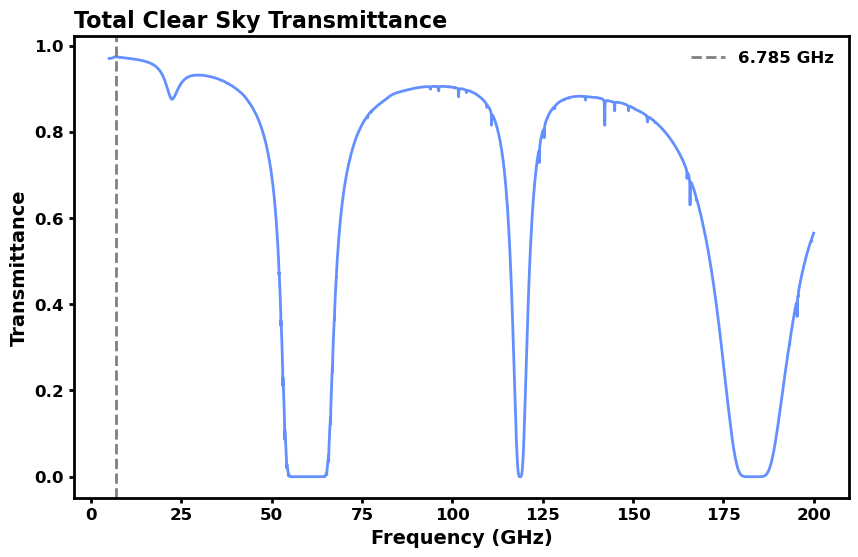

In [7]:
## PLOT CLEAR SKY TRANSMITTANCE AS A FUNCTION OF FREQUENCY
fig1, ax1 = plt.subplots(1,1, figsize = (10,6))
freq_of_max_t = FREQS[np.argmax(T_STAR_CLEAR)]

ax1.plot(FREQS, T_STAR_CLEAR,lw=2,c=IBM_BLUE)
ax1.axvline(freq_of_max_t, c = 'grey', ls = '--', label = f'{freq_of_max_t} GHz', lw=2)

ax1.set_xlabel("Frequency (GHz)",fontweight='bold',fontsize=14)
ax1.set_ylabel("Transmittance",fontweight='bold',fontsize=14)
ax1.set_title("Total Clear Sky Transmittance",fontweight='bold',fontsize=16,loc='left')

ax1.legend(frameon=False,prop={'weight':'bold','size':12})
bold_axes(ax1)

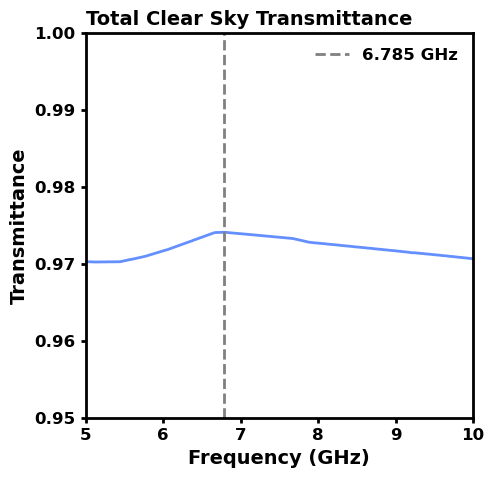

In [8]:
# Zooming into the frequency range with the highest transmittance
fig2, ax2 = plt.subplots(1,1, figsize = (5,5))

ax2.plot(FREQS, T_STAR_CLEAR,c=IBM_BLUE,lw=2)
ax2.axvline(freq_of_max_t, c = 'grey', ls = '--', label = f'{freq_of_max_t} GHz',lw=2)

ax2.set_xlabel("Frequency (GHz)",fontweight='bold',fontsize=14)
ax2.set_ylabel("Transmittance",fontweight='bold',fontsize=14)
ax2.set_title("Total Clear Sky Transmittance",fontweight='bold',fontsize=14,loc='left')

ax2.set_xlim([5,10])
ax2.set_ylim([0.95,1])

ax2.legend(frameon=False,prop={'weight':'bold','size':12})
bold_axes(ax2)

Given the high atmospheric transmission around 6.8 GHz, this should lead to the lowest uncertainty in our measurement, at least for this component of the uncertainty. Nice thing is the amount of water vapor barely affects the transmission in this range.

# Lake-effect Cloud Example (LWP = 0.1 kg/m^2)
## Brightness Temperature of the Lake Surface

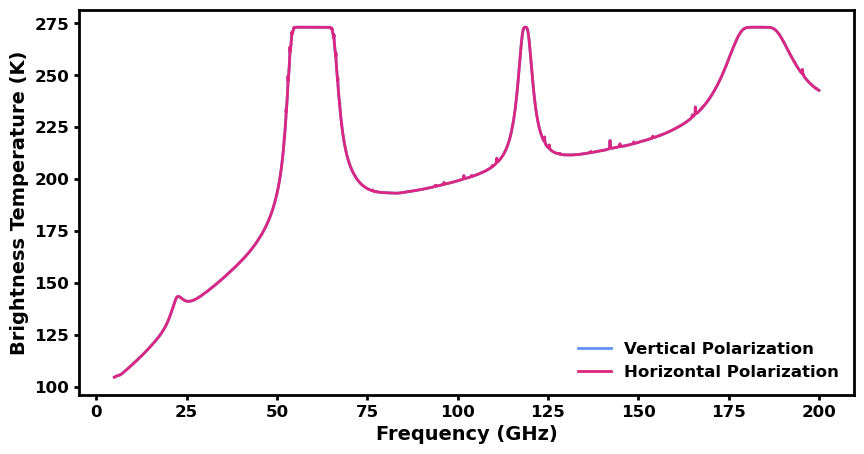

In [9]:
tb_Rv, tb_Rh = pfs.tb_polarization(LST_WINTER, FREQS, T_STAR_CLD_LE)

fig3, ax3 = plt.subplots(1, 1, figsize = (10,5))
ax3.plot(FREQS, tb_Rv, label = "Vertical Polarization", lw=2, c=IBM_BLUE)
ax3.plot(FREQS, tb_Rh, label = "Horizontal Polarization", lw=2, c=IBM_PINK)

ax3.set_xlabel("Frequency (GHz)",fontweight='bold',fontsize=14)
ax3.set_ylabel("Brightness Temperature (K)",fontweight='bold',fontsize=14)

bold_axes(ax3)
ax3.legend(frameon=False,prop={'weight':'bold','size':12})

Both polarizations give the exact same brightness temperatures, probably because we have no salinity. Varying the lake surface temperature does not change the slope much, so the sensitivity shouldn't vary too much with temperature. Varying the cloud temperature doesn't change the slope at all (only moves the line up or down) because it is only a multiplicative factor and isn't part of ocean_R. I think varying the liquid water path has the largest effect because it's part of the exponential for transmittance. Brightness temperature shoots up in the oxygen absorption bands because the radiance is purely from the cloud top (Temp of 0C) where we are assuming the emissivity is one (?) .

## Sensitivity of Brightness Temperature to LST
I stick to only plotting the vertical polarization here because it produces the same result as the horizontal. 

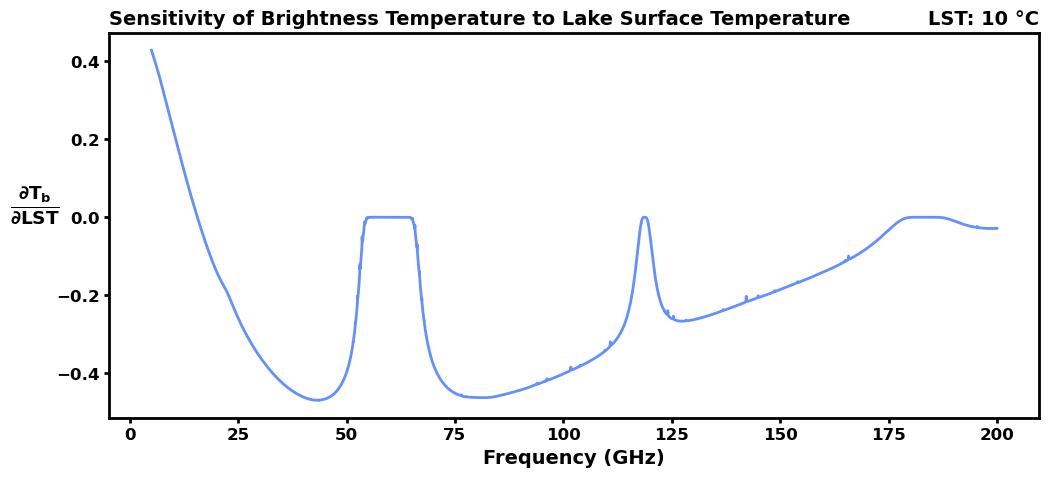

In [10]:
dtb_dlst_Rv, dtb_dlst_Rh = pfs.tb_sensitivity_lst(LST_SUMMER, DELTA_LST, FREQS, T_STAR_CLD_LE)

fig4, ax4 = plt.subplots(1, 1, figsize = (12,5))
ax4.plot(FREQS, dtb_dlst_Rv, lw=2, c=IBM_BLUE)

ax4.set_title("Sensitivity of Brightness Temperature to Lake Surface Temperature",
                fontweight='bold',fontsize=14,loc='left')
ax4.set_title(f"LST: {LST_SUMMER} \u00B0C",fontweight='bold',fontsize=14,loc='right')
ax4.set_xlabel("Frequency (GHz)",fontweight='bold',fontsize=14)
ax4.set_ylabel(r"$\mathbf{\frac{\partial T_b}{\partial LST}}$    ", 
                rotation = 0, fontsize = 19, fontweight='bold')
bold_axes(ax4)

## Sensitivity of Brightness Temperature to LWP

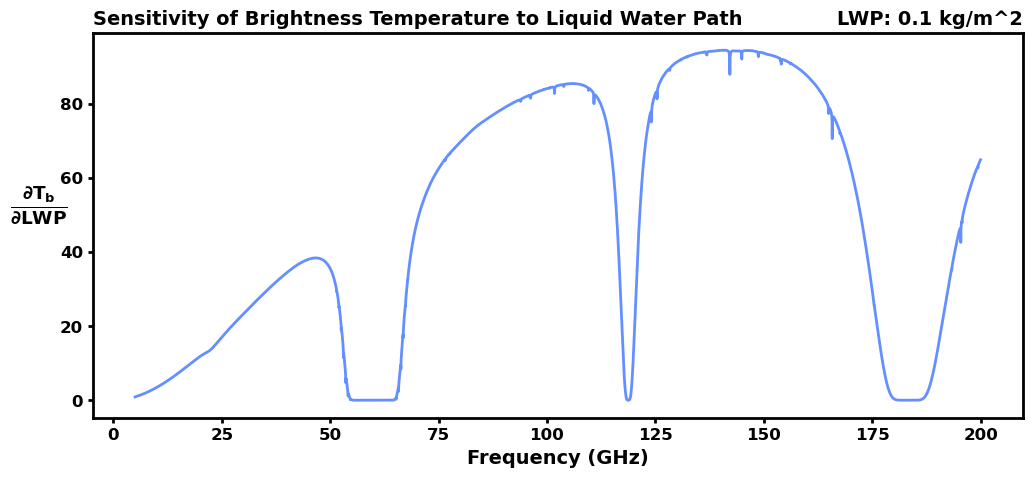

In [11]:
dtb_dlwp_Rv, dtb_dlwp_Rh = pfs.tb_sensitivity_lwp(LST_SUMMER, LWP_LE,
                                 DELTA_LWP, FREQS, df_liq_water, df_wv_gases)
                                              
fig5, ax5 = plt.subplots(1, 1, figsize = (12,5))
ax5.plot(FREQS, dtb_dlwp_Rv,lw=2, c=IBM_BLUE)

ax5.set_title("Sensitivity of Brightness Temperature to Liquid Water Path",
                fontweight='bold',fontsize=14,loc='left')
ax5.set_title(f"LWP: {LWP_LE} kg/m^2",fontweight='bold',fontsize=14,loc='right')
ax5.set_xlabel("Frequency (GHz)",fontweight='bold',fontsize=14)
ax5.set_ylabel(r"$\mathbf{\frac{\partial T_b}{\partial LWP}}$    ", 
                rotation = 0, fontsize = 19, fontweight='bold')
bold_axes(ax5)

## Total Uncertainty on LST

/Users/laratobias-tarsh/Documents/wn25/clim485/project/processing_fns.py:220: RuntimeWarning: divide by zero encountered in power
  term_1 = (NEDT**2) * (dTB_dLST**-2)
/Users/laratobias-tarsh/Documents/wn25/clim485/project/processing_fns.py:221: RuntimeWarning: divide by zero encountered in power
  term_2 = (delta_LWP**2) * (dTB_dLWP**2) * (dTB_dLST**-2)
/Users/laratobias-tarsh/Documents/wn25/clim485/project/processing_fns.py:221: RuntimeWarning: invalid value encountered in multiply
  term_2 = (delta_LWP**2) * (dTB_dLWP**2) * (dTB_dLST**-2)


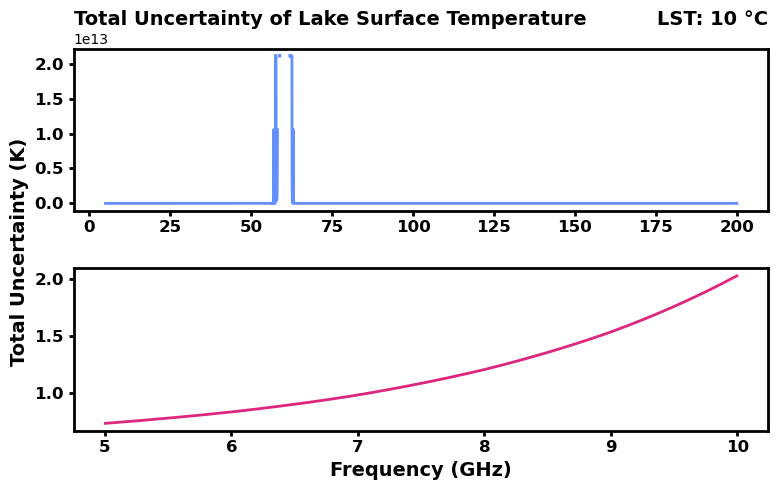

In [12]:
total_uncert = pfs.total_uncertainty(NEDT, dtb_dlst_Rv, dtb_dlwp_Rv, DELTA_LWP)

fig6, (ax6a,ax6b) = plt.subplots(2, 1, figsize = (8,5))
ax6a.plot(FREQS, total_uncert,lw=2,c=IBM_BLUE)
ax6b.plot(FREQS[:500], total_uncert[:500],lw=2,c=IBM_PINK)

ax6a.set_title("Total Uncertainty of Lake Surface Temperature",
                fontweight='bold',fontsize=14,loc='left')
ax6a.set_title(f"LST: {LST_SUMMER} \u00B0C",fontweight='bold',fontsize=14,loc='right')

ax6b.set_xlabel("Frequency (GHz)",fontweight='bold',fontsize=14)
ax6b.set_ylabel("Total Uncertainty (K)",fontweight='bold',fontsize=14,y=1.1)

[bold_axes(ax) for ax in [ax6a,ax6b]]

fig6.tight_layout()

The crazy values above are due to the thick absorption bands (we obviously don't want to use frequencies there). Below I plotted the total uncertainty in the first several frequencies where the transmission is highest.

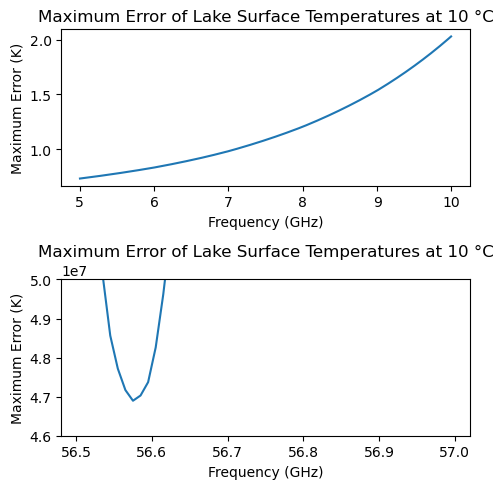

In [13]:
fig7, (ax7a, ax7b) = plt.subplots(2, 1, figsize = (5,5))
#ax.plot(freq, total_uncert)
ax7a.plot(FREQS[:500], total_uncert[:500])

ax7a.set_title("Maximum Error of Lake Surface Temperatures at 10 \u00B0C")
ax7a.set_xlabel("Frequency (GHz)")
ax7a.set_ylabel("Maximum Error (K)")


ax7b.plot(FREQS[5150:5200], total_uncert[5150:5200])
ax7b.set_ylim(46000000,50000000)

ax7b.set_title("Maximum Error of Lake Surface Temperatures at 10 \u00B0C")
ax7b.set_xlabel("Frequency (GHz)")
ax7b.set_ylabel("Maximum Error (K)")
fig7.tight_layout()

In [14]:
# Frequency with the lowest total uncertainty in the range plotted above
print('using argmin:')
freq_lowest_error = FREQS[np.argmin(total_uncert)]
print(f'idx: {np.argmin(total_uncert)}; freq: {freq_lowest_error}; value: {np.min(total_uncert)}')

print('using nanargmin:')
freq_lowest_error_nansafe = FREQS[np.nanargmin(total_uncert)]
print(f'idx: {np.nanargmin(total_uncert)}; freq: {freq_lowest_error_nansafe}; value: {np.nanmin(total_uncert)}')



using argmin:
idx: 5260; freq: 57.605; value: nan
using nanargmin:
idx: 0; freq: 5.005; value: 0.7317603347685563


The frequency associated with the lowest uncertainty of 5.005 GHz makes sense because, based on the equation we derived for the uncertainty, we would expect the lowest where the sensitivity to the lake surface temperature is maximized and where the sensitivity to liquid water path is minimized. The above sensitivity plots verify that this is true. When I find the frequency associated with the lowest uncertainty over the whole frequency range, it's around 57 GHz. But when I zoomed in the see what it was actually doing, this is on the edge of that major absorption band, and I think the numbers were making it bug out to an unrealistic value. Ask him about this too.